# This is my first notebook with Deep Learning and CNN, and I saw this dataset on Tensorflow in Practice Specialization on Coursera. I hope you'll like it. Please ask if you have any questions. I will be pleased if you upvote this notebook unless you don't like it. Thanks for your time. 

## Import necessary libraries

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from shutil import copyfile
from os import getcwd

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Extract train data from zip file.

In [ ]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('training_all')
zip_ref.close()

## Check if we unzipped correctly. os.listdir converts all files in directory to list, so we can use len with list.

In [ ]:
print(len(os.listdir('/kaggle/working/training_all/train')))

## Create folders for the train-set and validation-set. I created two different cats and dogs folder both in train and val. Because I am going to use ImageDataGenerator, the flow_from_directory method will identify classes automatically from the folder name. 

In [ ]:
base_dir = '/kaggle/working'
train_dir = os.makedirs(os.path.join(base_dir, 'train'))
validation_dir = os.makedirs(os.path.join(base_dir, 'validation'))

# Directory with our training cat pictures
train_cats_dir = os.makedirs('/kaggle/working/train/cats')

# Directory with our training dog pictures
train_dogs_dir = os.makedirs('/kaggle/working/train/dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.makedirs('/kaggle/working/validation/cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.makedirs('/kaggle/working/validation/dogs')

# We'll use 20% of the training-set as the validation-set.

# I copied all files in training to correct folders(cats or dogs) according to if they contain cat or dog in the file name.

In [ ]:
TRAIN_SOURCE = "/kaggle/working/training_all/train/"
TRAINING_CATS_DIR = "/kaggle/working/train/cats/"
VAL_CATS_DIR = "/kaggle/working/validation/cats/"
TRAINING_DOGS_DIR = "/kaggle/working/train/dogs/"
VAL_DOGS_DIR = "/kaggle/working/validation/dogs/"
SPLIT_SIZE = 0.8

list_images = os.listdir(TRAIN_SOURCE)
print(len(list_images))
files = []
for file_name in list_images:
    if(os.path.getsize(TRAIN_SOURCE + file_name)) > 0:
        files.append(file_name)
    else:
        print(file_name + "has zero length!")
        
files = random.sample(files, len(files))
train_set = files[0:round(SPLIT_SIZE*len(files))]
val_set = files[-(len(files) - len(train_set)):]
print("Train-set size:", len(train_set))
print("Validation-set size:", len(val_set))
for file_name in train_set:
    if('cat' in file_name):        
        copyfile(TRAIN_SOURCE + file_name, TRAINING_CATS_DIR + file_name)
    elif('dog' in file_name):
        copyfile(TRAIN_SOURCE + file_name, TRAINING_DOGS_DIR + file_name)
for file_name in val_set:
    if('cat' in file_name):        
        copyfile(TRAIN_SOURCE + file_name, VAL_CATS_DIR + file_name)
    elif('dog' in file_name):
        copyfile(TRAIN_SOURCE + file_name, VAL_DOGS_DIR + file_name)

In [ ]:
print('First 5 cats in training:', os.listdir(TRAINING_CATS_DIR)[0:5])
print('First 5 dogs in training:', os.listdir(TRAINING_DOGS_DIR)[0:5])
print('First 5 cats in validation:', os.listdir(VAL_CATS_DIR)[0:5])
print('First 5 dogs in validation:', os.listdir(VAL_DOGS_DIR)[0:5])

In [ ]:
print('# of cats in training-set:', len(os.listdir(TRAINING_CATS_DIR)), '\n# of dogs in training-set:', len(os.listdir(TRAINING_DOGS_DIR)))
print('# of cats in validation-set:', len(os.listdir(VAL_CATS_DIR)), '\n# of dogs in validation-set:', len(os.listdir(VAL_DOGS_DIR)))

# Create Model

In [ ]:
# EarlyStopping and Reduce Learning Rate Callbacks
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
my_callback_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.5, min_lr=0.00001, verbose=1)

model = tf.keras.models.Sequential([
    #Conv layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(132, 132, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    
])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

# Image augmentation with ImageDataGenerator

In [ ]:
TRAINING_DIR = "/kaggle/working/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    target_size=(132, 132))

VALIDATION_DIR =  "/kaggle/working/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size=16,
                                                             class_mode='binary',
                                                             target_size=(132, 132))

# Train

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = len(train_set) // 16,
    epochs = 100,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(val_set) // 16,
    callbacks=[my_callback_es, my_callback_rlr]
)

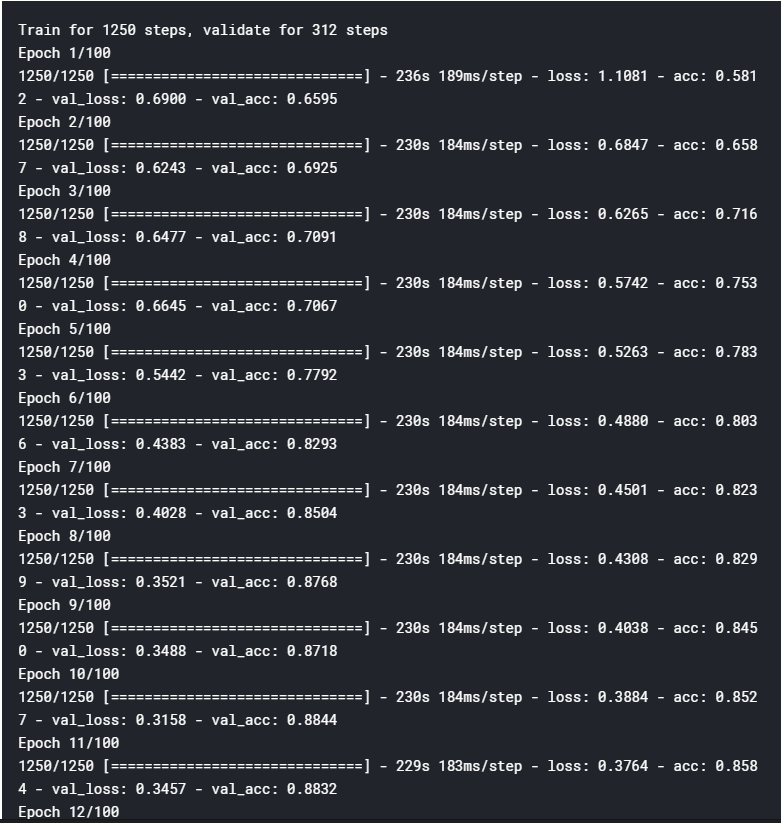
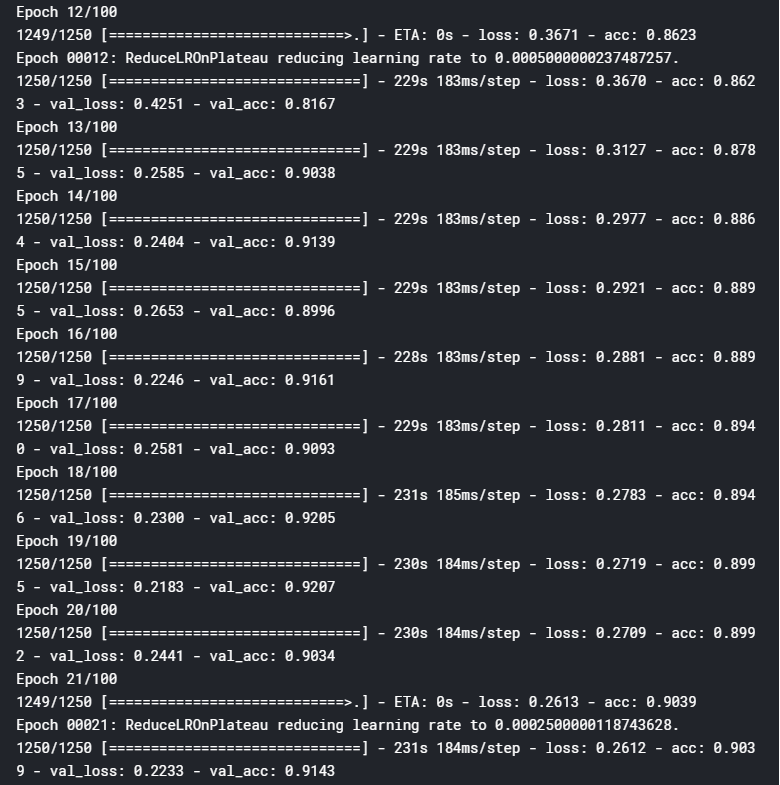
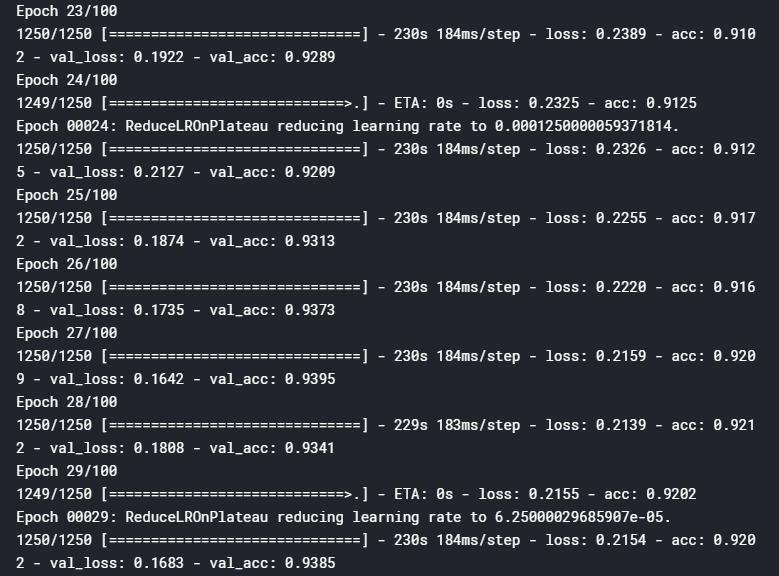
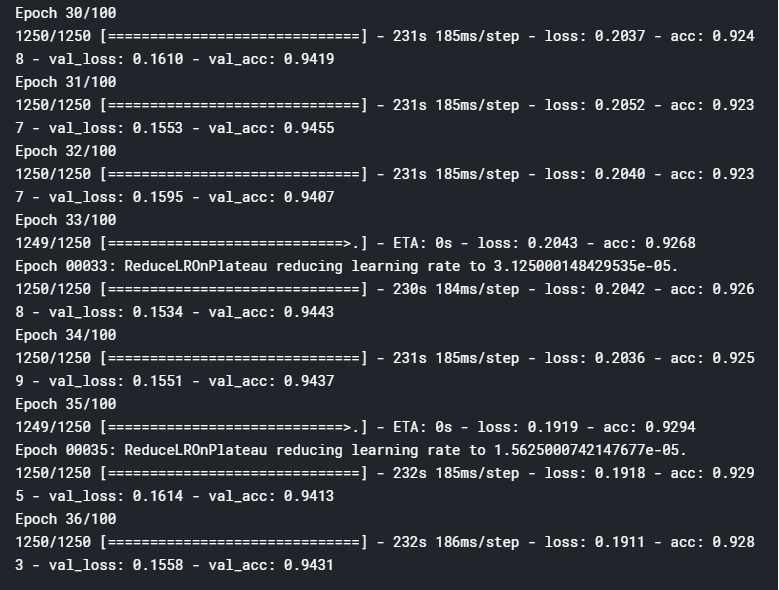

# Got ~0.95 validation accuracy and training stopped due to EarlyStopping callback. (If there are no improvement in validation-accuracy for five epochs, training stops.)

# Also learning rate dropped by half six times due to ReduceLROnPlateau callback. (If there is no improvement in validation-accuracy for two epochs, learning rate halves.)

# Visualize accuracies and losses.

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim(top=1.0)
plt.title('Training and validation loss')
plt.legend()

plt.show()

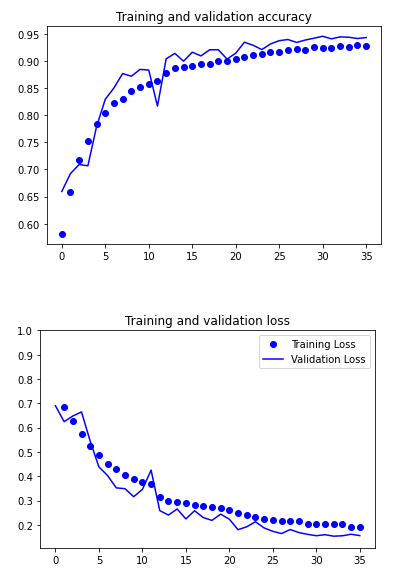

## Save the model and model weights. These files will going to output folder as expected. You can download them.

In [ ]:
model.save_weights('Dense1024_Dropout_model_wieghts.h5')
model.save('Dense1024_Dropout_model_keras.h5')

## Extract test data from zip file.

In [ ]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test_all')
zip_ref.close()

In [ ]:
test_images = os.listdir('/kaggle/working/test_all/test')
print(len(test_images))

## Check the test image formats.

In [ ]:
print(test_images[0:5])

In [ ]:
test_ids = [int(test_img[:-4]) for test_img in test_images]
print(test_ids[0:5])

## ImageDataGenerator again.

In [ ]:
TEST_DIR = "/kaggle/working/test_all/"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(132, 132),
                                                  batch_size=16,
                                                  class_mode='categorical',
                                                  shuffle=False)
test_generator.reset()
predictions = model.predict_generator(test_generator, verbose=1)

### Flatten predictions array to get 1-D array for submission.

In [ ]:
predictions = predictions.flatten()

## Save predictions.

In [ ]:
import pandas as pd

submission = pd.DataFrame({"id": test_ids, "label": predictions})
submission.to_csv("dogs_cats2.csv", index = False)
submission.head()

# There is an incompatibility between predict_generator and train,val generators. Indexes are not matching while predicting. There is no problem in the model, but submission scores just like random guessing. A lot of people on the internet mentioned this problem, but there is no simple solution to this. If I found a solution, I'll update the prediction part.

# Thank you! Please upvote if you liked it.